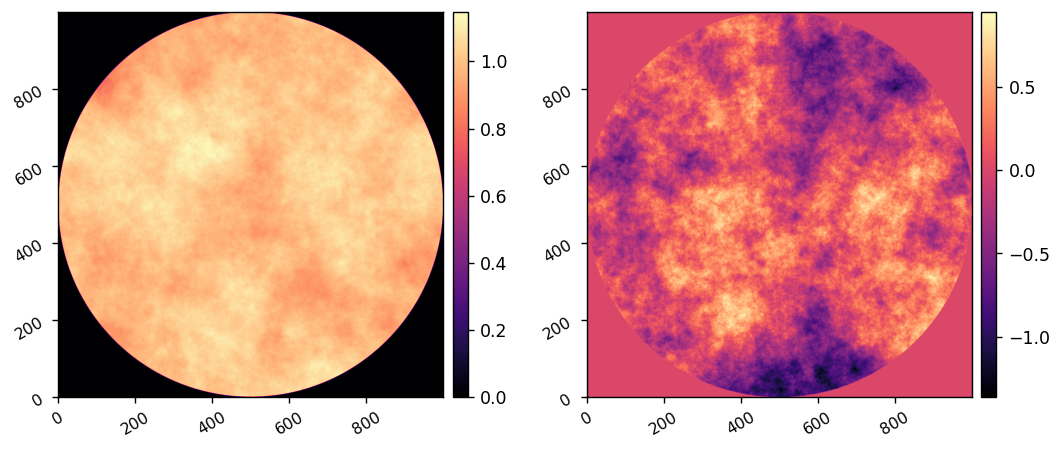

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.scoob_fraunhofer as scoob
import scoobpsf.utils as utils
import scoobpsf.dm as dm

import lina

wavelength_c = 633*u.nm
pupil_diam = 10*u.mm

reload(utils)
wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


(1000, 1000)
(2048, 2048)


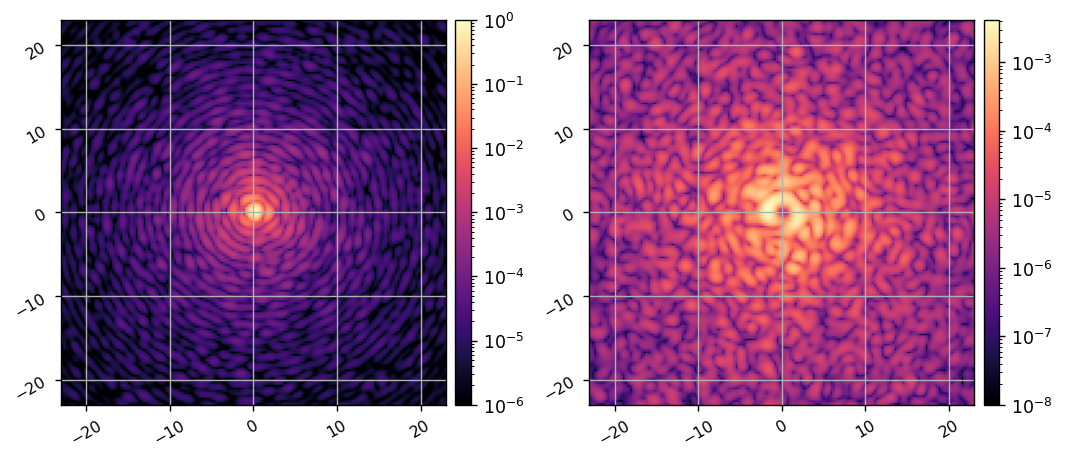

In [6]:
import copy
reload(scoob)
M = scoob.single()
M.setattr('WFE', WFE)

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

M.setattr('use_vortex', True)
M.use_scc(False)
ref_coro_im = M.snap()

imshow2(ref_psf/M.Imax_ref, ref_coro_im,
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=M.psf_pixelscale_lamD, grid=True, )

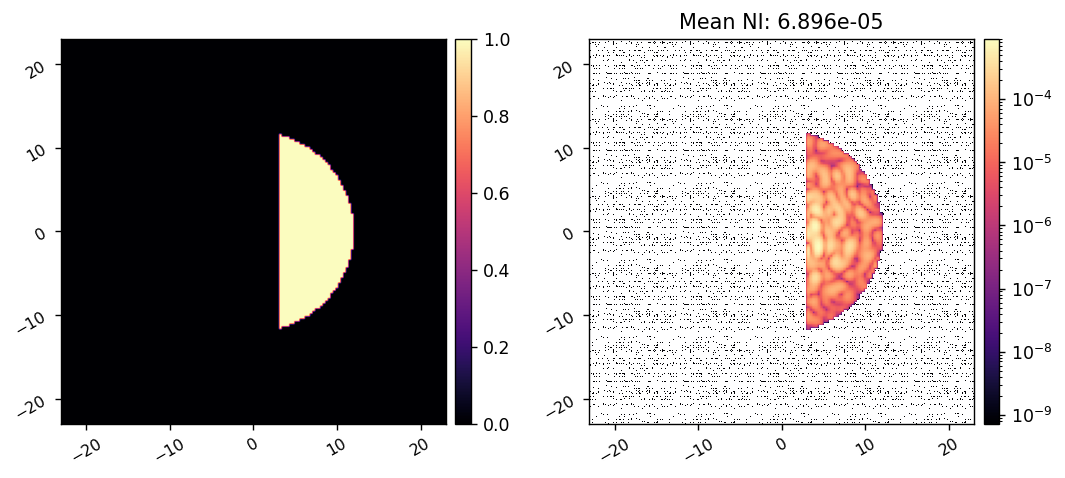

In [7]:
iwa = 3
owa = 12
control_mask = lina.utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamD, iwa, owa, edge=iwa)
mean_ni = xp.mean(ref_coro_im[control_mask])
imshow2(control_mask, control_mask*ref_coro_im, '', f'Mean NI: {mean_ni:.3e}', pxscl=M.psf_pixelscale_lamD, lognorm2=True)


In [8]:
reload(lina)
poke_amp = 1e-9
poke_modes = lina.utils.create_all_poke_modes(M.dm_mask)

Calculating Jacobian: 
(2048, 2048)
(2048, 2048)
(2048, 2048)response for mode 1/952. Elapsed time=0.028 sec.
(2048, 2048)
(2048, 2048)response for mode 2/952. Elapsed time=0.051 sec.
(2048, 2048)
(2048, 2048)response for mode 3/952. Elapsed time=0.075 sec.
(2048, 2048)
(2048, 2048)response for mode 4/952. Elapsed time=0.099 sec.
(2048, 2048)
(2048, 2048)response for mode 5/952. Elapsed time=0.123 sec.
(2048, 2048)
(2048, 2048)response for mode 6/952. Elapsed time=0.147 sec.
(2048, 2048)
(2048, 2048)response for mode 7/952. Elapsed time=0.172 sec.
(2048, 2048)
(2048, 2048)response for mode 8/952. Elapsed time=0.196 sec.
(2048, 2048)
(2048, 2048)response for mode 9/952. Elapsed time=0.220 sec.
(2048, 2048)
(2048, 2048)response for mode 10/952. Elapsed time=0.244 sec.
(2048, 2048)
(2048, 2048)response for mode 11/952. Elapsed time=0.267 sec.
(2048, 2048)
(2048, 2048)response for mode 12/952. Elapsed time=0.291 sec.
(2048, 2048)
(2048, 2048)response for mode 13/952. Elapsed time=0.315 sec

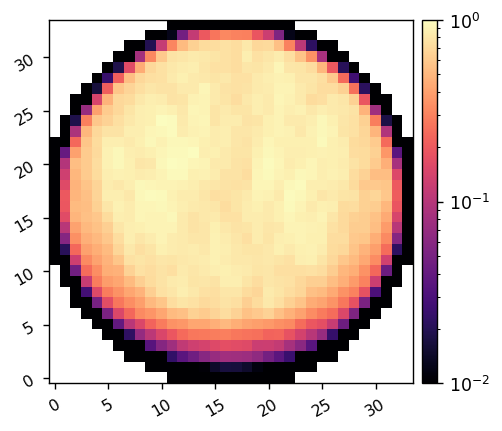

In [9]:
reload(lina.efc)
jac, response_cube = lina.efc.calibrate(M,
                                        poke_modes,
                                        #  poke_modes[800:951], 
                                        poke_amp,
                                        control_mask, 
                                        plot=True,
                                        return_all=True
                                        )

In [10]:
M.zero_dm()
all_ims = []
all_efs = []
all_commands = []

Beginning closed-loop EFC.
	Closed-loop iteration 16 / 18
Using model to compute electric field
(2048, 2048)
(2048, 2048)


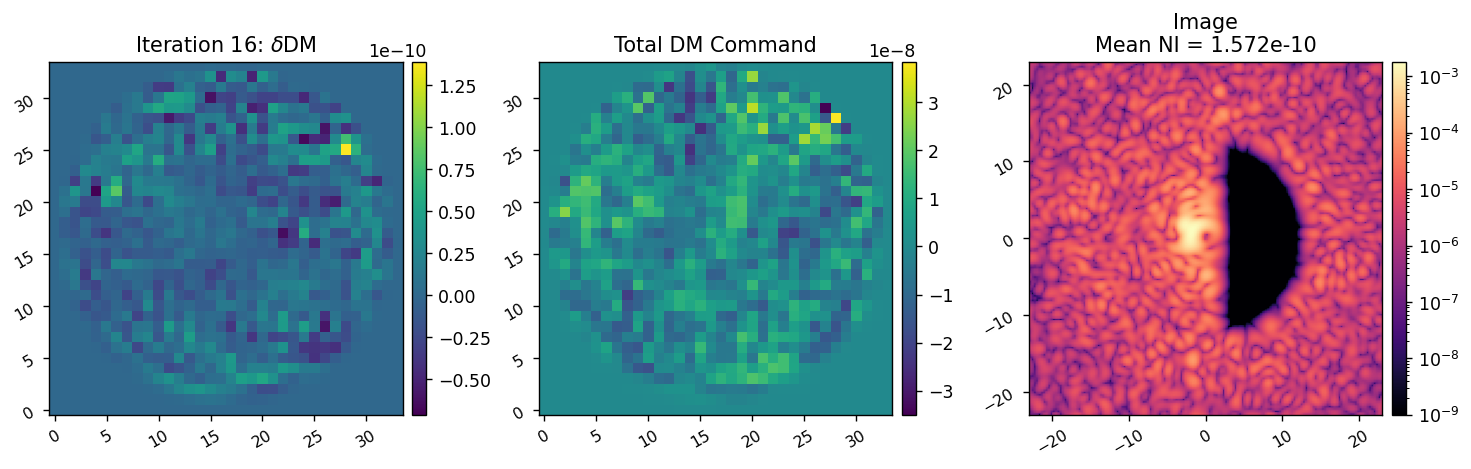

	Closed-loop iteration 17 / 18
Using model to compute electric field
(2048, 2048)
(2048, 2048)


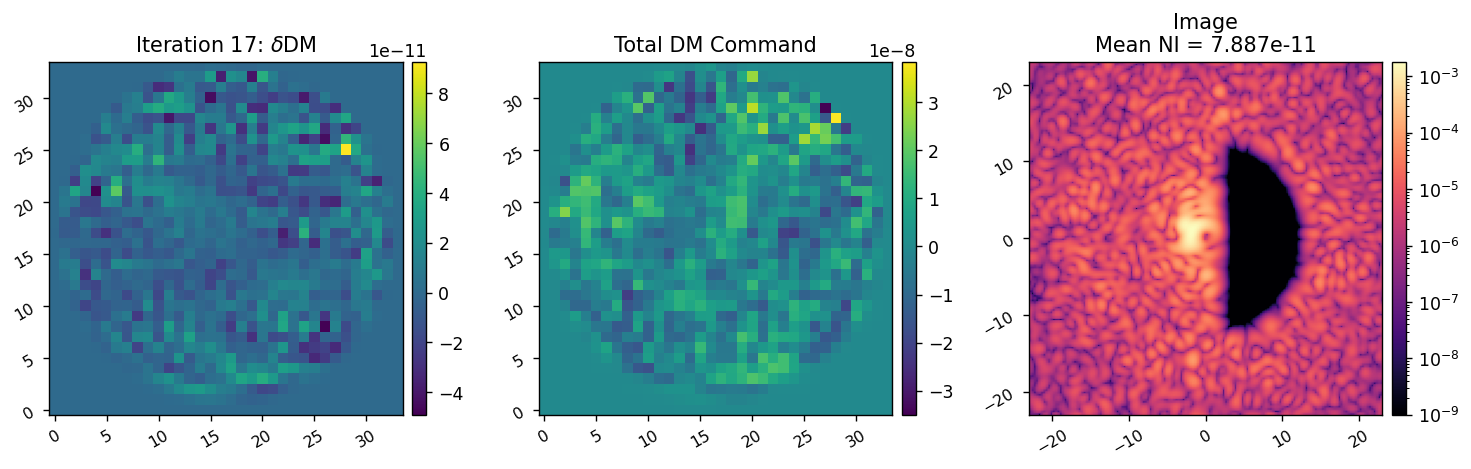

	Closed-loop iteration 18 / 18
Using model to compute electric field
(2048, 2048)
(2048, 2048)


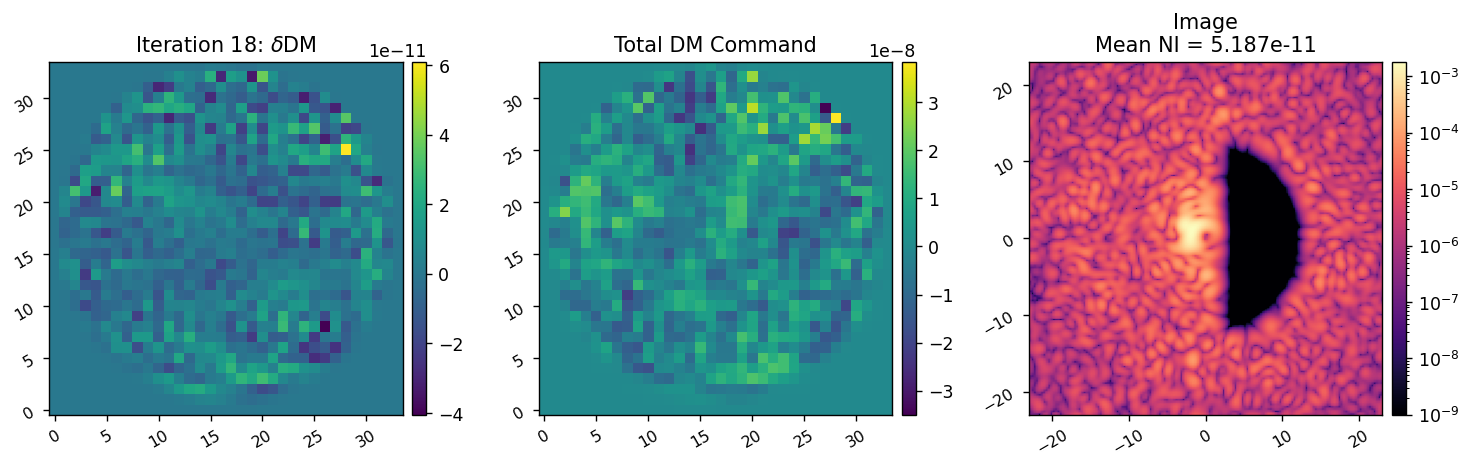

EFC completed in 2.191 sec.


In [16]:
reload(lina.efc)

control_matrix = lina.utils.beta_reg(jac, -2.5)
# control_matrix = lina.utils.beta_reg(jac, -5)

images, fields, dm_commands = lina.efc.run(M,
                                            control_matrix,
                                            poke_modes,
                                            control_mask, 
                                            # est_fun=est_fun,
                                            # est_params=est_params,
                                            loop_gain=0.5, 
                                            leakage=0.0,
                                            iterations=3, 
                                            plot_all=True, 
                                            plot_sms=False,
                                            plot_radial_contrast=False,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

In [17]:
utils.save_fits('scoob_fraunhofer_dh_commands_0.fits', xp.array(all_commands))

Saved data to:  scoob_fraunhofer_dh_commands_0.fits
